# Challenge 2: Kernel Ridge Regression and Kernel PCA

<a target="_blank" href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/notebooks/challenge-two.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The challenge is to show why it is better (or not) to use kernelised methods in two toy data sets, and find out which kernel is the most suitable for each.    
There are two main tasks:
1. Ridge Regression vs Kernel Ridge Regression
2. PCA vs Kernel PCA

Tip: *for the whole challenge, you can use ```sklearn```.*

## 1. Ridge Regression
Using the training and test data sets created in the following cell, what you have to do is:
* Fit a linear Ridge Regression model;
* Fit a Kernel Ridge Regression model with a Gaussian kernel and one with a Polynomial kernel. Through a grid search, see how different values for gamma for the Gaussian, and different degrees and values for the regularisation term for the Polynomial, change the line that gets fitted by the model.   
Lastly, fit one last KRR with the best kernel and best parameters that you found (the ones that minimise the test error).

For each subtask, calculate the RMSE on the test data set and plot a visual representation of each fitted line, also when trying different values for the parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd

def create_points(train_points, test_points):
    # create training dataset
    eps = np.random.normal(0, 1, train_points)

    X_train = np.linspace(-5, 5, train_points)
    X_train = X_train[:, np.newaxis]
    X_train = np.stack([X_train[:,0], np.ones(X_train.shape[0])], axis=1).reshape(-1,2)
    y_train = (X_train[:,0]+4) * (X_train[:,0]+1) * (np.cos(X_train[:,0])-1) * (X_train[:,0]-3) + eps
    y_train = y_train.reshape(-1,1)


    # create testing data set
    X_test = np.linspace(-5, 5, test_points)
    X_test = np.stack([X_test, np.ones(X_test.shape[0])], axis=1).reshape(-1,2)
    y_test = (X_test[:,0]+4) * (X_test[:,0]+1) * (np.cos(X_test[:,0])-1) * (X_test[:,0]-3)
    y_test = y_test.reshape(-1,1)
    
    return X_train, y_train, X_test, y_test

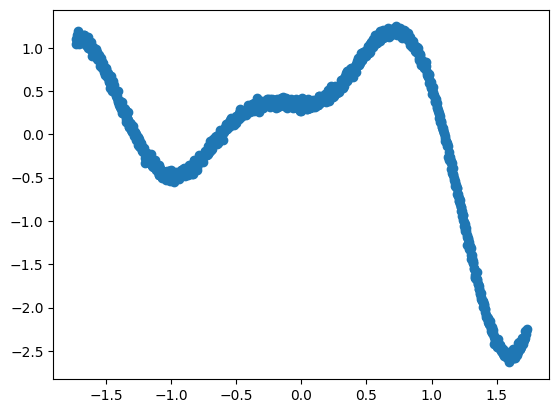

In [2]:
points = 1500
tr_pts = int(points*0.75)
ts_pts = points - tr_pts
X_train, y_train, X_test, y_test = create_points(tr_pts, ts_pts)

X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
y_train = preprocessing.StandardScaler().fit(y_train).transform(y_train)

plt.plot(X_train[:,0],y_train, 'o')

## Linear Ridge Regression

In [3]:
from sklearn.metrics import mean_squared_error

def ridge_coeff(X, y, lam):
    k = np.linalg.inv(np.dot(X.T,X) + lam * np.eye(X.shape[1]))
    w = np.dot(k,np.dot(X.T,y))
    return w

C:\Users\abdul\AppData\Local\Temp\ipykernel_22104\3726010579.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


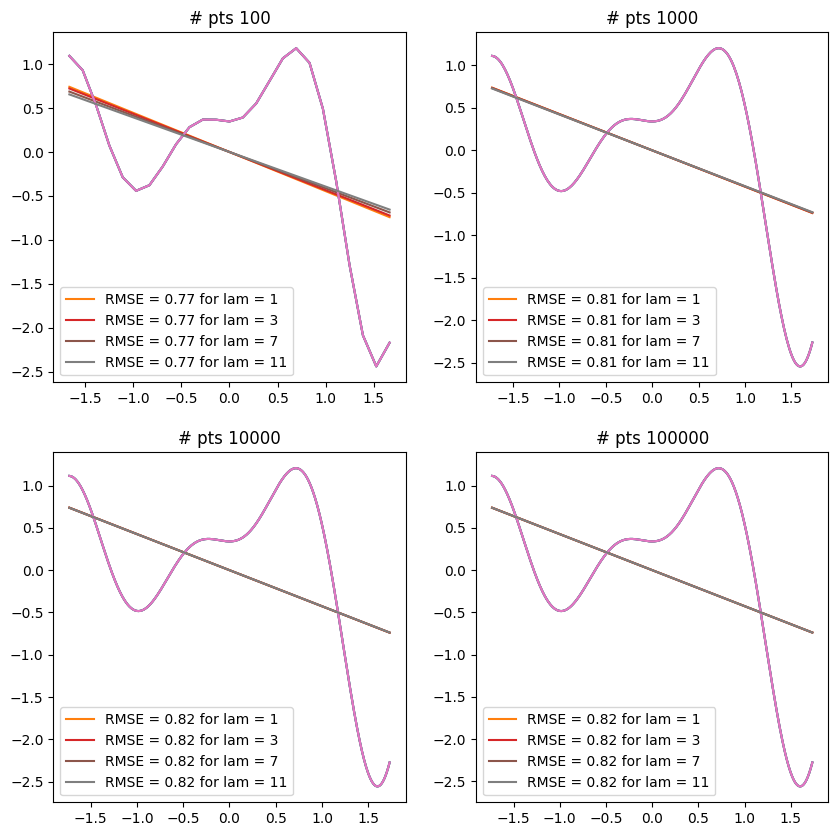

In [4]:
fig, axs =  plt.subplots(2,2, figsize=(10,10))
sizes = np.logspace(2, 5, num=4).astype(int)
lam = [1, 3, 7, 11]
for s, ax in zip(sizes, axs.ravel()):
    tr_pts = int(s*0.75)
    ts_pts = s - tr_pts
    X_train, y_train, X_test, y_test = create_points(tr_pts, ts_pts)

    X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
    y_train = preprocessing.StandardScaler().fit(y_train).transform(y_train)
    
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
    y_test = preprocessing.StandardScaler().fit(y_test).transform(y_test)
    
    for l in lam:
        w = ridge_coeff(X_train, y_train, l)
        y_pred = X_test[:,0]*w[0] + w[1]
        ax.plot(X_test[:,0], y_test)
        rmse = mean_squared_error(y_test, y_pred)
        ax.plot(X_test[:,0], y_pred, label=f"RMSE = {round(rmse, 2)} for lam = {l}")
        ax.legend(loc="lower left")
        ax.set_title(f"# pts {s}")
fig.show()

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

points = 2000
train_points = int(points*0.75) 
test_points = abs(points - train_points)

X_train, y_train, X_test, y_test = create_points(train_points, test_points)
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
y_train = preprocessing.StandardScaler().fit(y_train).transform(y_train)
    
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
y_test = preprocessing.StandardScaler().fit(y_test).transform(y_test)

In [6]:
krr_gaus = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.linspace(0,5,50)},
)

krr_linear = GridSearchCV(
    KernelRidge(kernel='linear', alpha=0.01),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3]},
)

In [7]:
krr_gaus.fit(X_train, y_train)

print("KRR gaussina")
print(f"Best KRR with params: {krr_gaus.best_params_} and R2 score: {krr_gaus.best_score_:.3f}")

print("\n")

krr_linear.fit(X_train, y_train)
print("KRR linear")
print(f"Best KRR with params: {krr_linear.best_params_} and R2 score: {krr_linear.best_score_:.3f}")

KRR gaussina
Best KRR with params: {'alpha': 0.001, 'gamma': 1.4285714285714286} and R2 score: 0.905


KRR linear
Best KRR with params: {'alpha': 1.0} and R2 score: -13.952


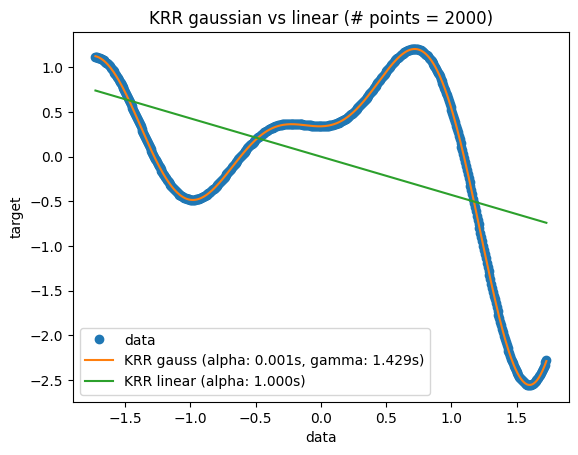

In [8]:
y_krr_gaus = krr_gaus.predict(X_test)
y_krr_linear = krr_linear.predict(X_test)

plt.plot(X_test[:,0], y_test, "o", label="data",)

plt.plot(
    X_test[:,0], y_krr_gaus, label="KRR gauss (alpha: %.3fs, gamma: %.3fs)" % (krr_gaus.best_params_['alpha'], krr_gaus.best_params_['gamma'])
)
plt.plot(
    X_test[:,0], y_krr_linear, label="KRR linear (alpha: %.3fs)" % (krr_linear.best_params_['alpha'])
)
plt.xlabel("data")
plt.ylabel("target")
plt.title(f"KRR gaussian vs linear (# points = {points})")
_ = plt.legend()

This figure compares the time for fitting and prediction of KRR-gaus and KRR-linear for different sizes of the training set. Fitting KRR-linear is faster than KRR-gaus for medium-sized training sets (less than a few thousand samples); however, for larger training sets KRR-gaus scales better. With regard to prediction time, KRR-linear should be faster than KRR-gaus for all sizes of the training set because of the learned sparse solution

C:\Users\abdul\AppData\Local\Temp\ipykernel_25512\881414270.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


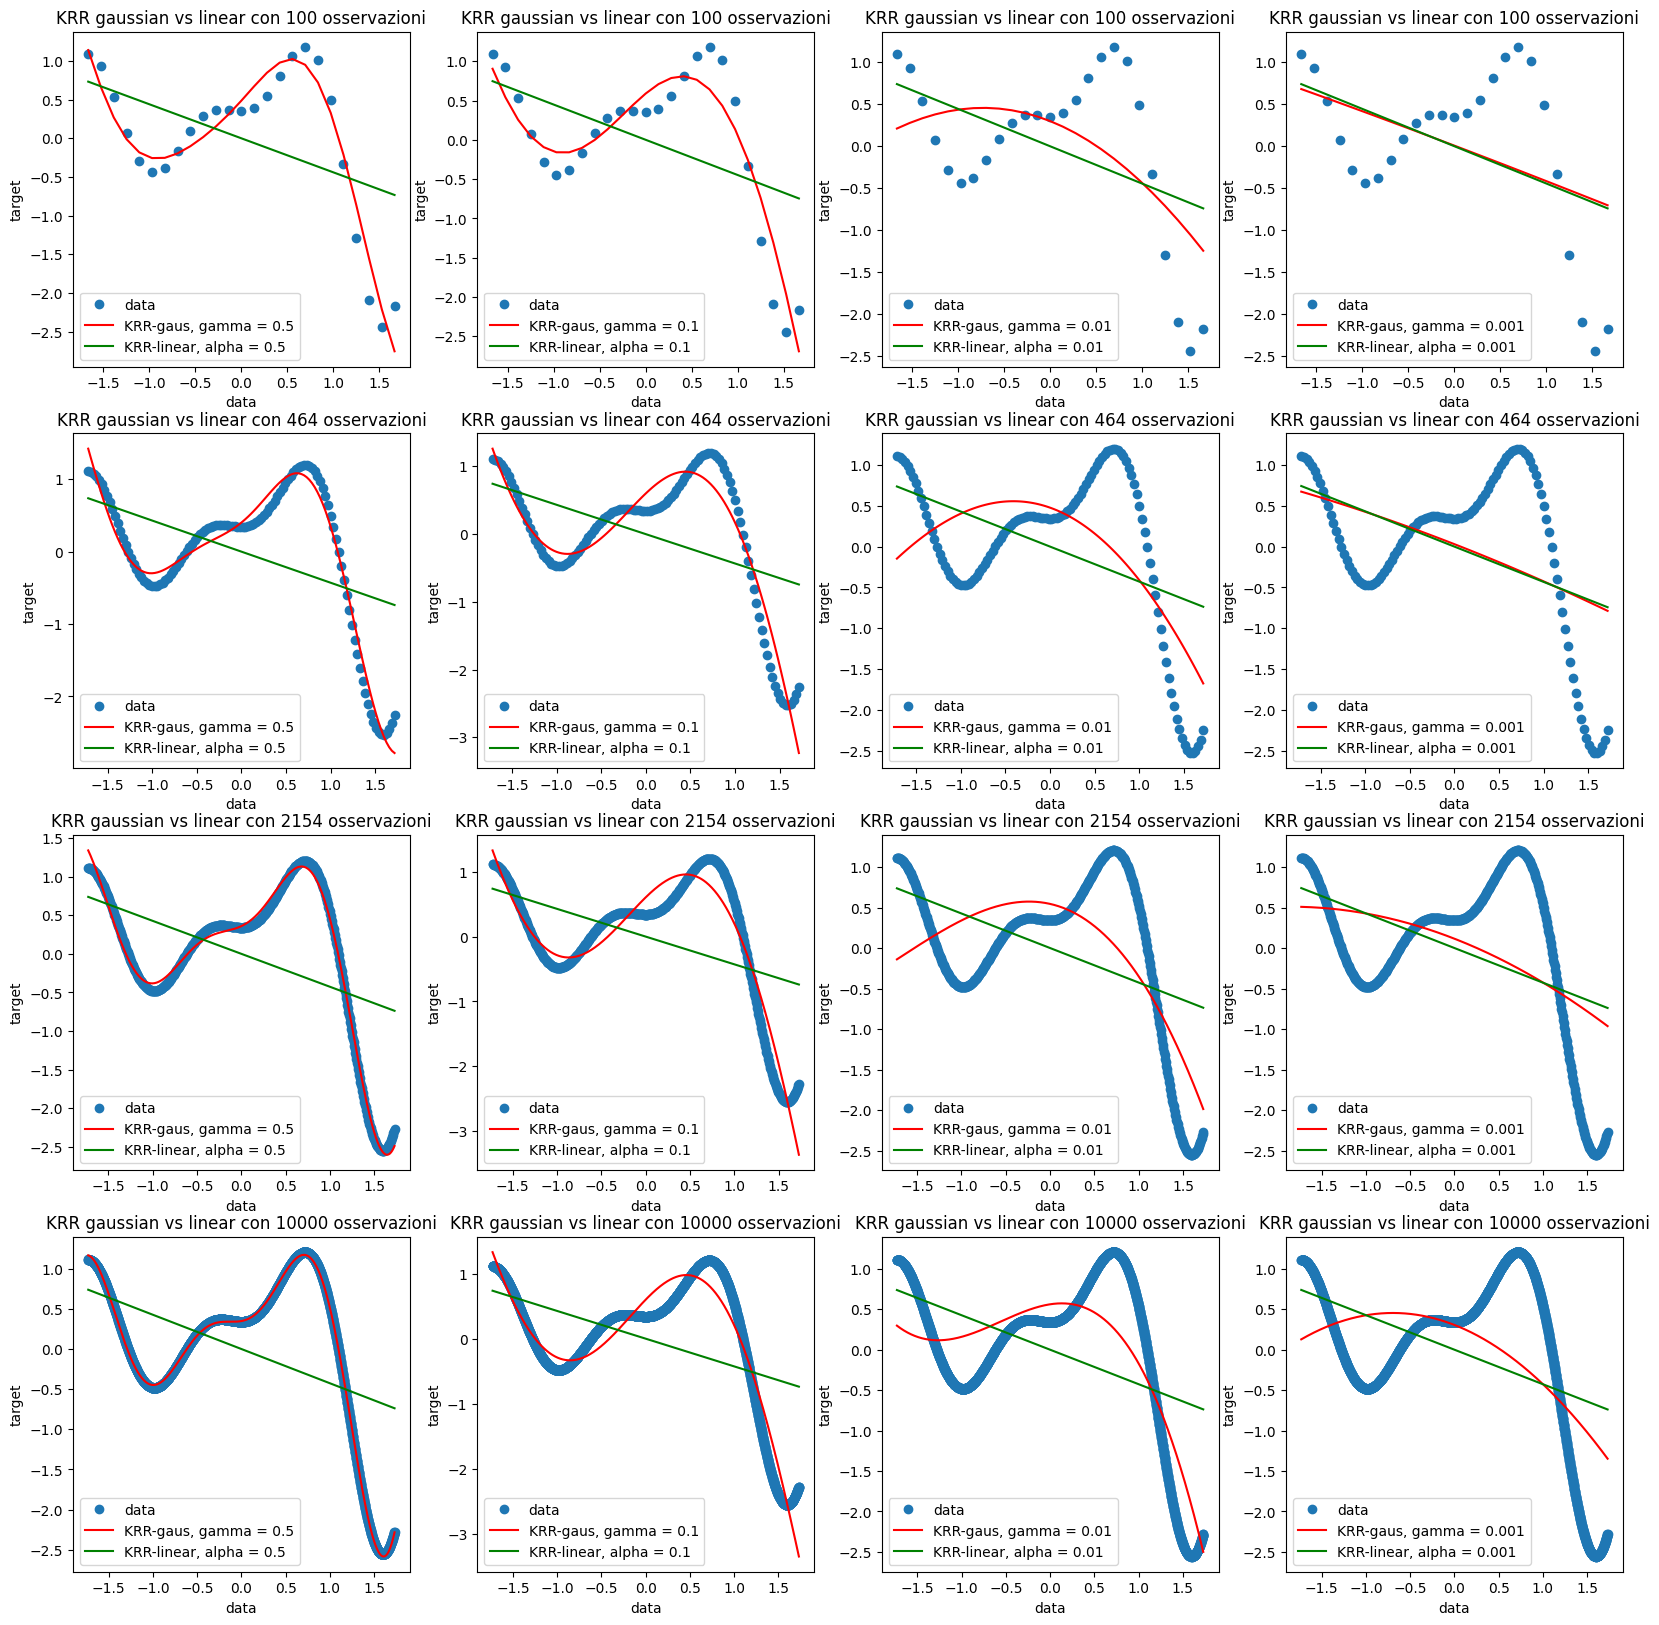

In [9]:
from itertools import product
sizes = np.logspace(2, 4, num=4).astype(int)
sizes = sizes.tolist()

gammas = [0.5, 0.1, 0.01, 0.001]

fig, axs = plt.subplots(4, 4, figsize=(20,20))

for gs, ax in zip(product(sizes, gammas), axs.ravel()):
    
    
    tr_pts = int(gs[0]*0.75)
    ts_pts = gs[0] - tr_pts
    X_train, y_train, X_test, y_test = create_points(tr_pts, ts_pts)
    
    X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
    y_train = preprocessing.StandardScaler().fit(y_train).transform(y_train)
        
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
    y_test = preprocessing.StandardScaler().fit(y_test).transform(y_test)
    
    ax.plot(X_test[:,0], y_test, "o", label="data")
    for name, estimator in{
        f"KRR-gaus, gamma = {gs[1]}": KernelRidge(kernel="rbf", alpha=0.01, gamma=gs[1]),
        f"KRR-linear, alpha = {gs[1]}": KernelRidge(kernel="linear", alpha=gs[1]),
    }.items():    
        
        krr_fit = estimator.fit(X_train, y_train)
        
        krr_predict = estimator.predict(X_test)
        
    
        ax.plot(
            X_test[:,0], 
            krr_predict,
            color="r" if name == f"KRR-gaus, gamma = {gs[1]}" else "g",
            label=f"{name}"
        )
    

    ax.set_xlabel("data")
    ax.set_ylabel("target")
    ax.set_title(f"KRR gaussian vs linear con {gs[0]} osservazioni")
    ax.legend(loc="best")

fig.show()

## 2. PCA
Using the training and test data sets created in the following cell, what you have to do is:
* Fit a PCA model;
* Fit a Kernel PCA model with a kernel of your choice.

For each subtask, plot a visual representation of the projections and verify the accuracy of that kernel on the test data set using SVM.

In [5]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

#accuracy per SVC
def acc(labels, predlabels):
     return np.count_nonzero(labels == predlabels)/len(labels)

X, y = make_circles(n_samples=1000, noise=0.15, factor=0.2, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=0)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA

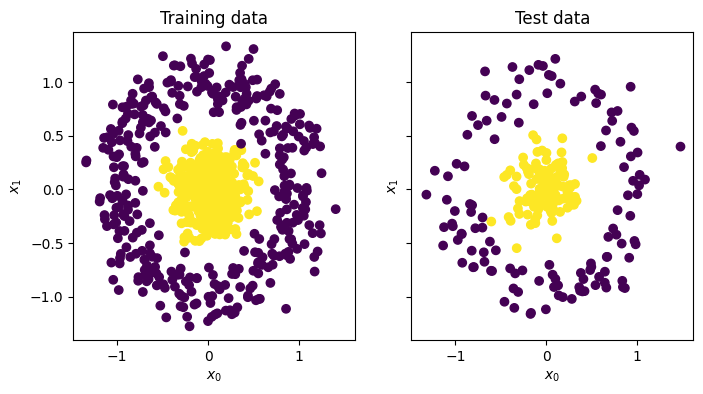

In [7]:
# Visualize the data
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,cmap='viridis')
train_ax.set_xlabel("$x_{0}$")
train_ax.set_ylabel("$x_{1}$")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,cmap='viridis')
test_ax.set_xlabel("$x_{0}$")
test_ax.set_ylabel("$x_{1}$")
test_ax.set_title("Test data")
plt.show()

#### Apply PCA

There are several issues with the dataset above, the first being samples from each class cannot be linearly separated: no plane can split the samples of the inner ring from the outer ring. Let's see what happens when we perform PCA and evaluate the projection or score.

In [8]:
from sklearn.decomposition import PCA

# Fit on a PCA object
pca = PCA(n_components=2)

score_pca = pca.fit(X_train).transform(X_test)

We can plot the 2 principal components:

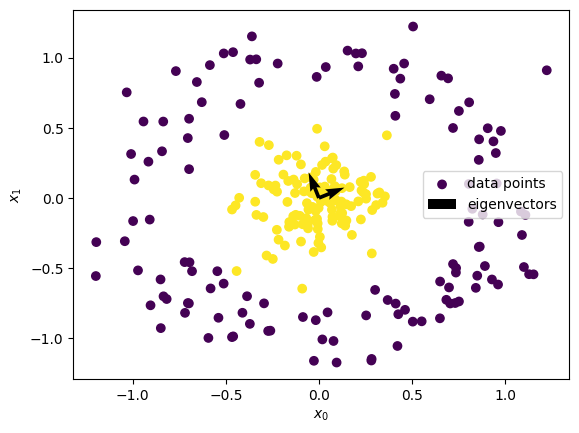

In [9]:
plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test,label="data points", cmap='viridis')
plt.quiver([0,0],[0,0], pca.components_[0,:], pca.components_[1,:], label="eigenvectors")
plt.xlabel("$x_{0}$")
plt.ylabel("$x_{1}$")
plt.legend(loc='center right')
plt.show()

We can also plot out the actual points of projection onto the first principal component, which are also known as their scores for the PC. We see that the dataset is not linearly separable, as data points from different classes cannot be separated with a plane:

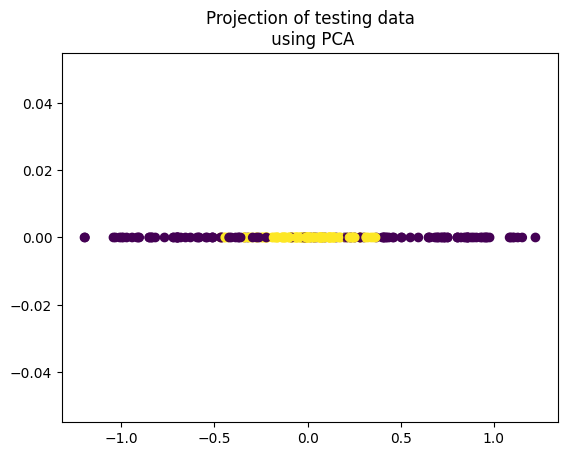

In [10]:
plt.scatter(score_pca [:,0],np.zeros(score_pca[:,0].shape[0]),c=y_test,cmap='viridis')
plt.title("Projection of testing data\n using PCA")
plt.show()

If we plot the projection onto both principal components, we see the data looks the same, or isotropic, meaning that it has the same value when measured in a different coordinate system. This is because the data is symmetric and the variance is equal on each side. As a result, PCA will not help us classify the data.

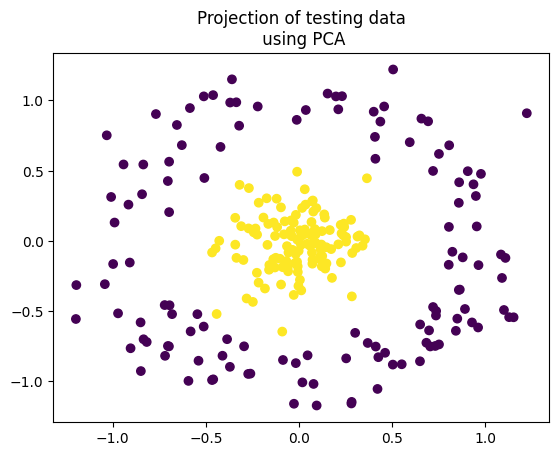

In [11]:
plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test,cmap='viridis')
plt.title("Projection of testing data\n using PCA")
plt.show()

Building a SVM model on the training set, we can see that the accuracy score is around 50%, suggesting that the model is arbitrarily worse. Hence, we can see that it'd be unsuitable to project the data onto a low-dimensional linear subspace.

In [12]:
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(X_train, y_train)

y_pred_sk = svc.predict(X_test)
print('Accuracy with sklearn: ', acc(y_test, y_pred_sk))

Accuracy with sklearn:  0.496


##### Transform a Dataset to a Higher Dimension and then Apply PCA

Instead, let's first apply the following polynomial transformation to the data:
$$
\phi(x)=[x_1,x_2,(x_1)^2+(x_2)^2]
$$
 where $ x=[x_1,x_2]$

In [13]:
PHI_train=np.concatenate((X_train, (X_train**2).sum(axis=1).reshape(-1,1)),axis=1)
PHI_test=np.concatenate((X_test, (X_test**2).sum(axis=1).reshape(-1,1)),axis=1)

We can plot the result where on the horizontal axis we have $(x_1)$
  and  $(x_2)$
 , and on the vertical axis we have  $(x_1)^2 + (x_2)^2$
 . We see that the larger ring has been mapped upwards in the vertical direction as the sum of its squared components is larger.

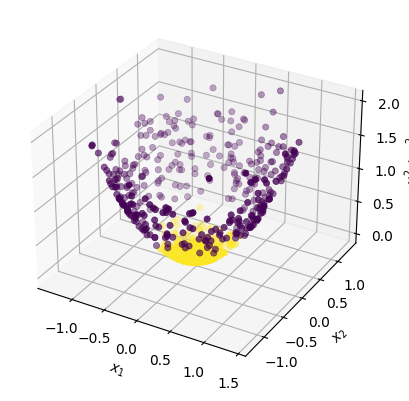

In [14]:
# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(PHI_train[:,0], PHI_train[:,1],  PHI_train[:,2], c=y_train, cmap='viridis', linewidth=0.5);
ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')
ax.set_zlabel('$x_{1}^2+x_{2}^2$')
plt.show()

We then perform PCA on this transformed data, specifying we want to keep the top three principal components.



In [15]:
pca = PCA(n_components=2)
score_polly = pca.fit(PHI_train).transform(PHI_test)

Again, like we have previously done, we can plot out the data points' projection onto the first PC/scores. Below, we see that the dataset is almost linearly separable.

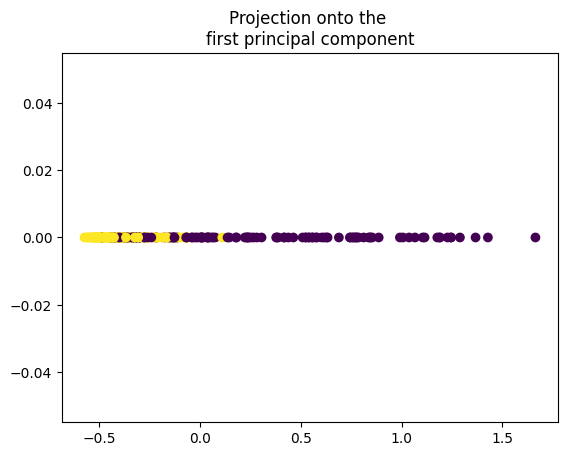

In [16]:
plt.scatter(score_polly[:,0],np.zeros(score_polly[:,1].shape[0]),c=y_test,cmap='viridis')
plt.title("Projection onto the \nfirst principal component")
plt.show()

Projecting onto a plane formed by the top two principal components (the ones with the largest absolute eigenvalues), we see the dataset is linearly separable with the exception of a couple of points.

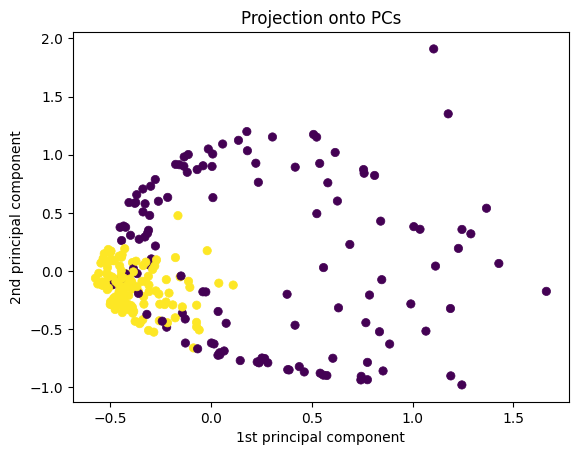

In [17]:
plt.scatter(score_polly[:,0], score_polly[:,1],c=y_test, cmap='viridis', linewidth=0.5);
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Projection onto PCs")
plt.show()

By building a SVM model on the training set, we see the accuracy is much better

In [18]:
svc = LinearSVC().fit(PHI_train, y_train)
svc.score(PHI_test, y_test)

0.996

#### Apply kernel PCA

### Gaussiano

In [19]:
kernel_pca = KernelPCA(kernel="rbf", gamma=5, alpha=0.2)

X_train_kernel_pca = kernel_pca.fit(X_train).transform(X_train)
X_test_kernel_pca = kernel_pca.fit(X_train).transform(X_test)

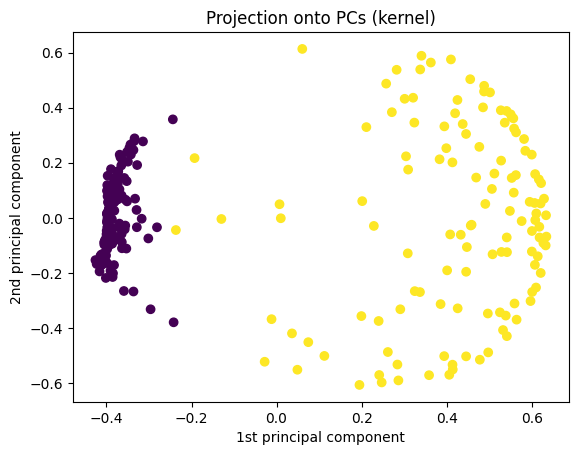

In [20]:
plt.scatter(X_test_kernel_pca[:,0],X_test_kernel_pca[:,1] ,c=y_test)
plt.title("Projection onto PCs (kernel)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

In [21]:
svm = LinearSVC().fit(X_train_kernel_pca, y_train)
y_pred_sk = svm.predict(X_test_kernel_pca)
print('Accuracy with sklearn: ', acc(y_test, y_pred_sk))

Accuracy with sklearn:  0.992


## 3. PCA pt.2
Repeat the last point of the previous task with a dataset made with ```sklearn.datasets.make_classification()```. Find the best kernel, and comment on your discoveries in the report. What differences do you see with the previous data set?

In [22]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, StandardScaler


X, y = make_classification(n_samples=1000, random_state=100)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=100)

# Min-Max Scaling
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit(X_train).transform(X_test)

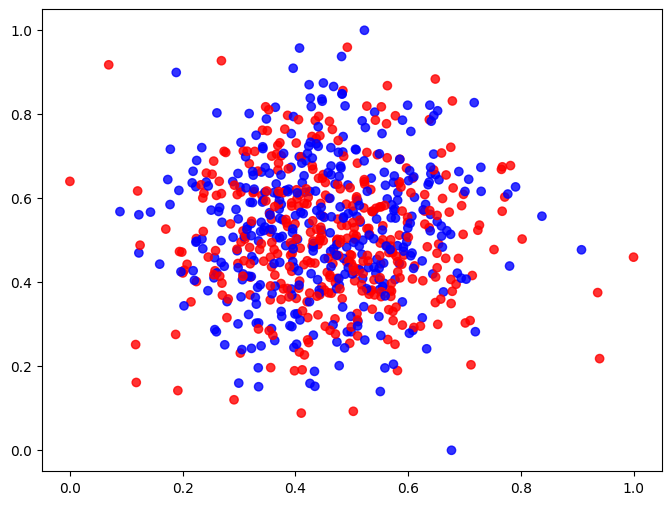

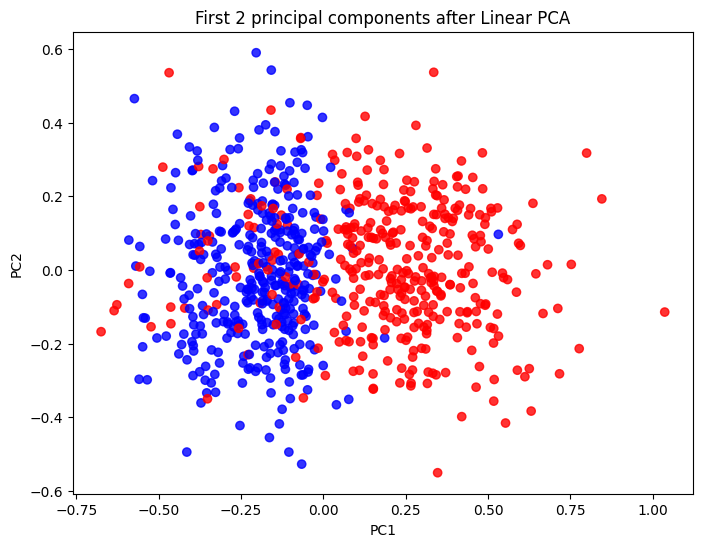

In [23]:
#plot no PCA
plt.figure(figsize=(8,6))
plt.scatter(X_train_normalized[:,0], X_train_normalized[:,1], c=y_train, cmap='bwr', alpha=0.8)

#linear
scikit_pca = PCA(n_components=2)
X_train_spca = scikit_pca.fit(X_train_normalized).transform(X_train_normalized)
X_test_spca = scikit_pca.fit(X_train_normalized).transform(X_test_normalized)

plt.figure(figsize=(8,6))
plt.scatter(X_train_spca[:,0], X_train_spca[:,1], c=y_train, cmap='bwr', alpha=0.8)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [24]:
svc = LinearSVC().fit(X_train_spca, y_train)
y_pred_sk = svc.predict(X_test_spca)
print('Accuracy with sklearn: ', acc(y_test, y_pred_sk))

Accuracy with sklearn:  0.904


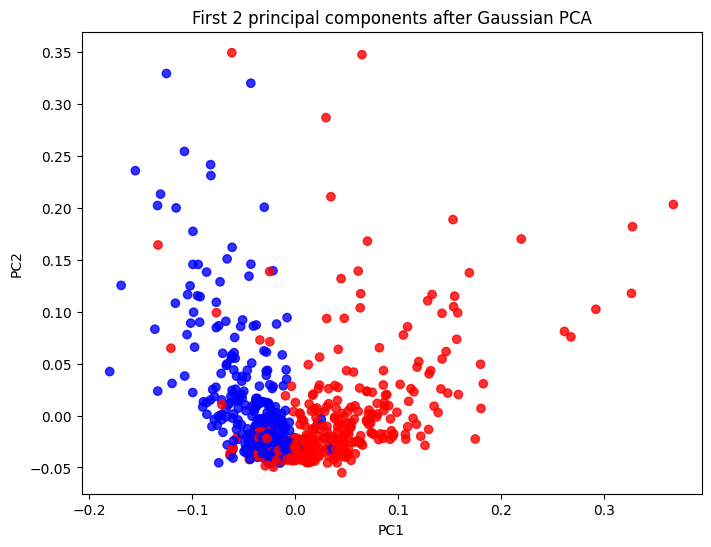

In [25]:
#gaussian
kernel_pca = KernelPCA(n_components=None, kernel="rbf", gamma=9, alpha=0.5)

X_tr_skernelpca = kernel_pca.fit_transform(X_train_normalized)
X_ts_skernelpca = kernel_pca.fit(X_train_normalized).transform(X_test_normalized)

plt.figure(figsize=(8,6))
plt.scatter(X_tr_skernelpca[:,0], X_tr_skernelpca[:,1], c=y_train, cmap='bwr', alpha=0.8)

plt.title('First 2 principal components after Gaussian PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [26]:
svc = LinearSVC().fit(X_tr_skernelpca, y_train)
y_pred_sk = svc.predict(X_ts_skernelpca)
print('Accuracy with sklearn: ', acc(y_test, y_pred_sk))

Accuracy with sklearn:  0.952


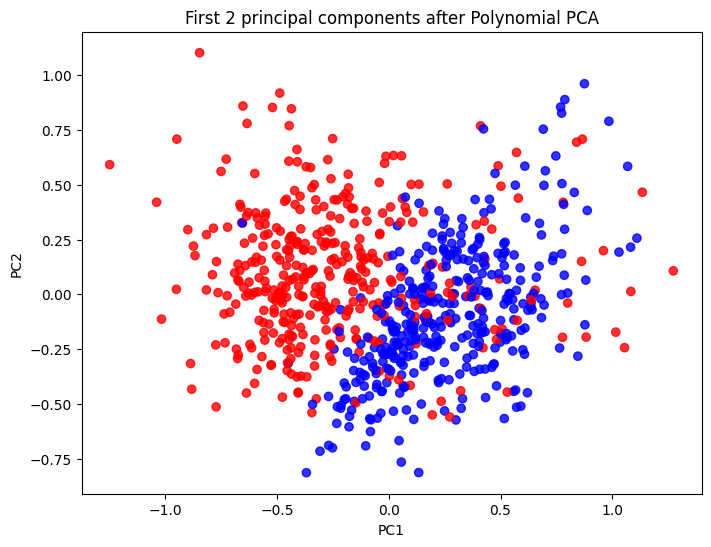

In [30]:
#polynomial
poly_pca = KernelPCA(n_components=None, kernel="poly", coef0=1, degree=8)

X_tr_polypca = poly_pca.fit(X_train_normalized).transform(X_train_normalized)
X_ts_polypca = poly_pca.fit(X_train_normalized).transform(X_test_normalized)

plt.figure(figsize=(8,6))
plt.scatter(X_tr_polypca[:,0], X_tr_polypca[:,1], c=y_train, cmap='bwr', alpha=0.8)

plt.title('First 2 principal components after Polynomial PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [31]:
svc = LinearSVC().fit(X_tr_polypca, y_train)
y_pred_sk = svc.predict(X_ts_polypca)
print('Accuracy with sklearn: ', acc(y_test, y_pred_sk))

Accuracy with sklearn:  0.948


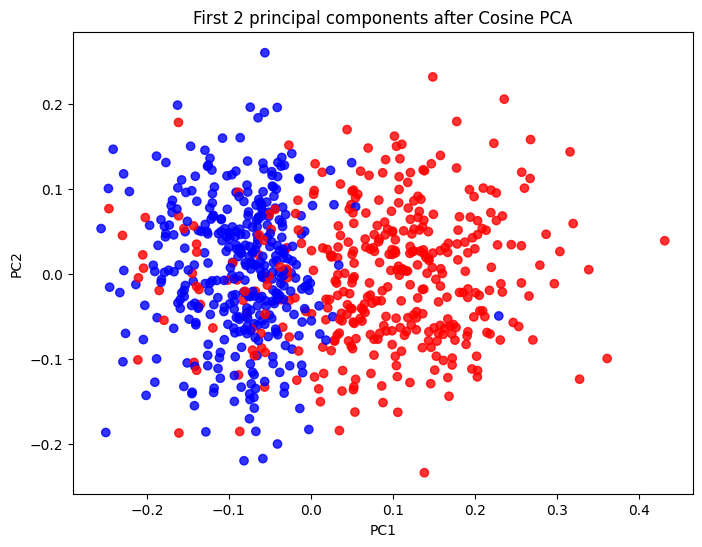

In [32]:
#cosine
cosine_pca = KernelPCA(n_components=None, kernel="cosine")

X_tr_cosinepca = cosine_pca.fit(X_train_normalized).transform(X_train_normalized)
X_ts_cosinepca = cosine_pca.fit(X_train_normalized).transform(X_test_normalized)


plt.figure(figsize=(8,6))
plt.scatter(X_tr_cosinepca[:,0], X_tr_cosinepca[:,1], c=y_train, cmap='bwr', alpha=0.8)

plt.title('First 2 principal components after Cosine PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [34]:
svc = LinearSVC().fit(X_tr_cosinepca, y_train)
y_pred_sk = svc.predict(X_ts_cosinepca)
print('Accuracy with sklearn: ', acc(y_test, y_pred_sk))

Accuracy with sklearn:  0.94
